In [1]:
# ------------------------------------------------- #
# This notebook is used to compare the performance  #
# of scarlet1 and 2 on fitting a single source      #
# with an intentionally poor initialised spectrum   #
# Author: Matt Sampson Sept. 2023                   #
# ------------------------------------------------- #

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install galaxygrad==0.0.19
#!pip install galaxygrad==0.0.14

In [4]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
from numpyro.distributions import constraints
import scarlet2
from scarlet2 import *
import matplotlib.pyplot as plt
import pandas as pd
from scarlet2 import nn
from scarlet2 import relative_step
from functools import partial
import cmasher as cmr

/Users/mattsampson/miniconda3/lib/python3.9/site-packages/jaxtyping/__init__.py:210: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


In [5]:
# plot params
plt.rcParams["xtick.top"] = True 
plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.direction"] = 'in' 
plt.rcParams["ytick.direction"] = 'in' 
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["xtick.minor.size"] = 4.5
plt.rcParams["ytick.major.size"] = 7
plt.rcParams["ytick.minor.size"] = 4.5
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["xtick.minor.width"] = 1.5
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["ytick.minor.width"] = 1.5
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({"text.usetex": True})
#plt.style.use('dark_background')

In [6]:
# define the norm which is used in all scarlet1 tests
# create the individual sources
from astropy.visualization.lupton_rgb import AsinhMapping
stretch = 1
Q = 20
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

In [7]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #

# read in the single test galaxy from HSC
data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
src_num = 12490 #15333 # 15110
data = df[df['parent_ID']==df['parent_ID'][src_num]] 
#data = df[df['parent_ID']==df['parent_ID'][15333]] 
#data = pd.read_pickle('data_test.pkl')

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

# box and center params
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )

# set it up for scarlet
images = multi_images 
weights = 1/multi_var 
frame_psf = GaussianPSF(0.7)
model_frame = Frame(
                Box(images.shape), 
                psf=frame_psf)
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
obs.match(model_frame);
print('----------------------------------------')
print(f"    Scene contains {len(centers)} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 4 galaxy sources
----------------------------------------


In [8]:
# create Gaussian profiles for blank initialisation
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    """2D Gaussian function."""
    return np.exp(-((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2)))

def create_gaussian_array(size, sigma_x, sigma_y):
    """Create a 2D array with a Gaussian profile in the center."""
    x = jnp.linspace(-size/2, size/2, size)
    y = jnp.linspace(-size/2, size/2, size)
    x, y = jnp.meshgrid(x, y)
    # Center of the Gaussian profile
    mu_x, mu_y = 0, 0
    # Generate the Gaussian profile
    gaussian_profile = gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y)
    return gaussian_profile

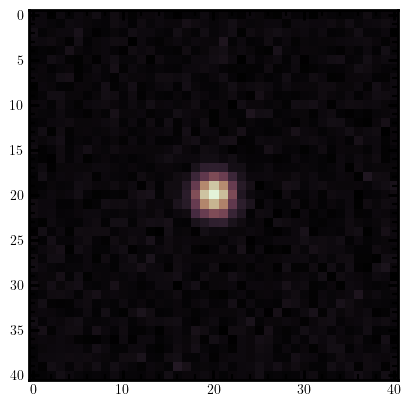

In [9]:
# empty list
morph_inits = [None]*len(centers)
scarlet1_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .02 # noise factor

for i, bx in enumerate(box_size):
    sigma_x = 1.5
    sigma_y = 1.5
    noise = random.normal(key, (box_size[i], box_size[i]))
    gaussian_array = create_gaussian_array(box_size[i], sigma_x, sigma_y)
    initial_model = gaussian_array + sigma * noise
    normed = (initial_model-jnp.min(initial_model))/(jnp.max(initial_model)-jnp.min(initial_model)) 
    morph_inits[i] = normed
    # add scarlet initialisation, use i-band here for no significant reason
    #scarlet1_init[i] = np.array([np.array(data['scar_i'])[i] ])[0]

plt.imshow(morph_inits[0], cmap='cmr.sepia')

# load the scarlet 1 initialisations
scarlet1_spec = np.load('scarlet1_spectrum.npy', allow_pickle=True)
scarlet1_morph = np.load('scarlet1_morph.npy', allow_pickle=True)
scarlet1_spec_best = np.load('scarlet1_spectrum_best.npy', allow_pickle=True)

In [10]:
# load in the model you wish to use
from galaxygrad import HSC_ScoreNet64, HSC_ScoreNet32, ZTF_ScoreNet32, ZTF_ScoreNet64
prior_model = HSC_ScoreNet64
#prior_model = ZTF_ScoreNet64
model_size = 64

def transform(x):
    sigma_y = 0.10
    return jnp.log(x + 1) / sigma_y

/Users/mattsampson/miniconda3/lib/python3.9/site-packages/diffrax/custom_types.py:133: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(0))
/Users/mattsampson/miniconda3/lib/python3.9/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-val

In [11]:
prior_test = nn.ScorePrior( model=prior_model, 
                            transform=transform, 
                            model_size=model_size
                            )

# sample = prior_test.draw_sample(box_size=20)
# plt.imshow(sample, cmap='cmr.sepia')
# plt.colorbar()

In [12]:
# Load up the Scene with inits and prior selected
# from the scarlet 1 poor model
keys = random.split(random.PRNGKey(0), 2)
spec_step = partial(relative_step, factor=1e-3)
with Scene(model_frame) as scene1:
    for i in range(len( centers )):
        # define new prior here for each new model
        prior = nn.ScorePrior(  model=prior_model, 
                                transform=transform, 
                                model_size=model_size)
        Source(
            centers[i],
            ArraySpectrum(Parameter(scarlet1_spec[i],
                                    constraint=constraints.positive, 
                                    stepsize=spec_step)),
            ArrayMorphology(Parameter(scarlet1_morph[i],
                                    prior=prior, 
                                    constraint=constraints.positive, 
                                    stepsize=5e-3))
        )
        
# now fit the model
#%time scene_bad = scene1.fit(obs, max_iter=200, e_rel=1e-4)
scene_bad = scene1.fit(obs, max_iter=250, e_rel=1e-4)
renders_bad = obs.render(scene_bad())

100%|██████████| 250/250 [00:09<00:00, 25.22it/s, loss=11991.16]


In [13]:
# Load up the Scene with constraints and prior selected
keys = random.split(random.PRNGKey(0), 2)
#spec_step = partial(relative_step, factor=2e-2)
with Scene(model_frame) as scene2:
    for i in range(len( centers )):
        # define new prior here for each new model
        prior = nn.ScorePrior(  model=prior_model, 
                                transform=transform, 
                                model_size=model_size)
        #morph_init = prior.draw_sample(box_size=box_size[i])
        Source(
            centers[i],
            ArraySpectrum(Parameter(scarlet1_spec_best[i],
                                    #jnp.ones(5), 
                                    constraint=constraints.positive, 
                                    stepsize=spec_step)),
            ArrayMorphology(Parameter(#scarlet1_morph[i],
                                    morph_inits[i],
                                    prior=prior, 
                                    constraint=constraints.positive, 
                                    stepsize=5e-3))
        )
        
# now fit the model
#%timeit scene_flat = scene2.fit(obs, max_iter=200, e_rel=1e-4)
scene_flat = scene2.fit(obs, max_iter=250, e_rel=1e-4)
renders_flat = obs.render(scene_flat())

100%|██████████| 250/250 [00:09<00:00, 26.49it/s, loss=12603.32]


In [14]:
# Load up the Scene with inits and prior selected
# from the scarlet 1 poor model
keys = random.split(random.PRNGKey(0), 2)
spec_step = partial(relative_step, factor=2e-2)
with Scene(model_frame) as scene3:
    for i in range(len( centers )):
        # define new prior here for each new model
        prior = nn.ScorePrior(  model=prior_model, 
                                transform=transform, 
                                model_size=model_size)
        Source(
            centers[i],
            ArraySpectrum(Parameter(scarlet1_spec_best[i],
                                    constraint=constraints.positive, 
                                    stepsize=spec_step)),
            ArrayMorphology(Parameter(scarlet1_morph[i],
                                    prior=prior, 
                                    constraint=constraints.positive, 
                                    stepsize=1e-3))
        )
        
# now fit the model
#%time scene_bad = scene1.fit(obs, max_iter=200, e_rel=1e-4)
scene_best = scene3.fit(obs, max_iter=100, e_rel=1e-4)
renders_best = obs.render(scene_best())

100%|██████████| 100/100 [00:05<00:00, 19.23it/s, loss=11542.59]


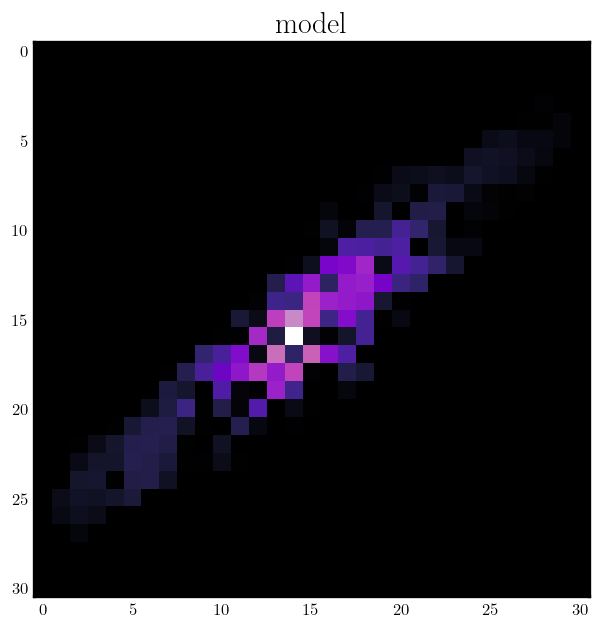

<Figure size 640x480 with 0 Axes>

In [15]:
# These should look far more like actual galaxies with the neural network acting as a constraint
cmap = 'cmr.gothic'
fig, axes = plt.subplots(1, 1, figsize=(15,6),dpi=120)
y = scene_bad.sources[0].morphology() 
axes.imshow(y, cmap = cmap) 
axes.set_title(f"model", fontsize = 18)
plt.show()
plt.clf()

# Lets take a look at the differences

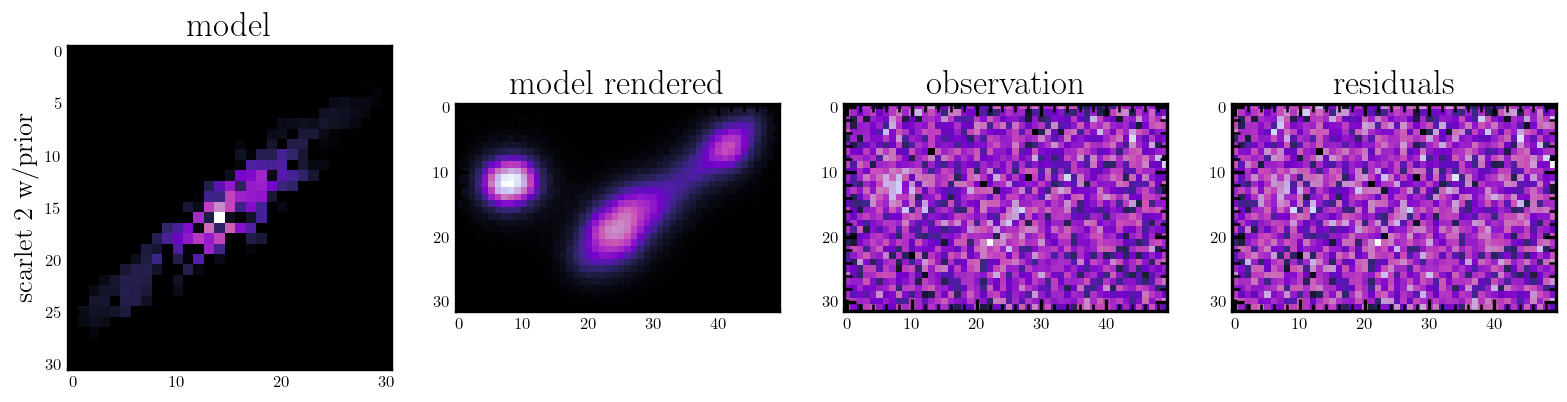

<Figure size 640x480 with 0 Axes>

In [16]:

fig, axes = plt.subplots(1, 4, figsize=(16,3.5),dpi=120)
#cmap = 'cmr.sepia'
band_list = ['g-band', 'r-band', 'i-band', 'y-band', 'z-band']

# ------------------ #
# Scarlet 2 plotting #
# ------------------ #

# the model
y = scene_bad.sources[0].morphology() 
axes[0].imshow(y, cmap = cmap)
axes[0].set_title('model', fontsize = 21)
axes[0].set_ylabel('scarlet 2 w/prior', fontsize = 16)

# the renders
y2 = renders_bad[0]
axes[1].imshow(y2, cmap = cmap)
axes[1].set_title('model rendered', fontsize = 21)

# the observations
axes[2].imshow(obs.data[0], cmap = cmap)
axes[2].set_title('observation', fontsize = 21)

# the residuals
axes[3].imshow(obs.data[0] - y2, cmap = cmap)
axes[3].set_title('residuals', fontsize = 21)


#fig.tight_layout()
plt.savefig('bad_init_test_scar2.png', dpi=120)
plt.show()
plt.clf()

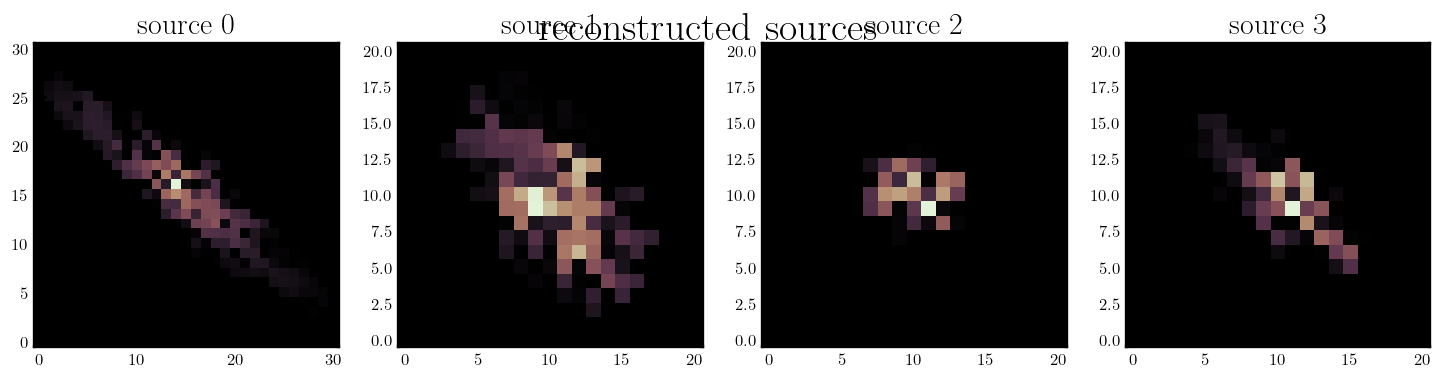

<Figure size 640x480 with 0 Axes>

In [17]:
# These should look far more like actual galaxies with the neural network acting as a constraint
fig, axes = plt.subplots(1, len( scene_bad.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene_bad.sources[i].morphology() 
    ax.imshow(y, cmap = 'cmr.sepia') 
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

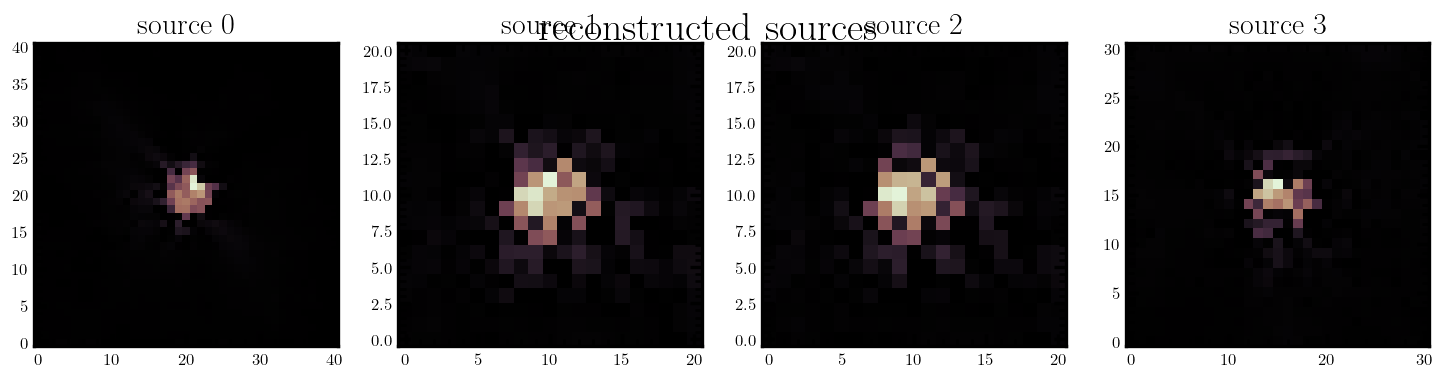

<Figure size 640x480 with 0 Axes>

In [18]:
# These should look far more like actual galaxies with the neural network acting as a constraint
fig, axes = plt.subplots(1, len( scene_flat.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene_flat.sources[i].morphology() 
    ax.imshow(y, cmap = 'cmr.sepia') 
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('reconstructed sources', fontsize=24,y=0.75)
plt.show()
plt.clf()

In [19]:
# load in scarlet 1 data
#from display import img_to_rgb
scarlet1_model = np.load('scarlet1_model.npy')
scarlet1_render = np.load('scarlet1_render.npy')
scarlet1_obs = np.load('scarlet1_obs.npy')
scarlet1_resid = np.load('scarlet1_resid.npy')
scarlet1_mod = np.load('scarlet1_model_bands.npy')

scarlet1_model_best = np.load('scarlet1_model_best.npy')
scarlet1_render_best = np.load('scarlet1_render_best.npy')
scarlet1_obs_best = np.load('scarlet1_obs_best.npy')
scarlet1_resid_best = np.load('scarlet1_resid_best.npy')
scarlet1_mod_best = np.load('scarlet1_model_bands_best.npy')

In [20]:
resids = obs.data - scarlet1_mod
residuals_rgb = scarlet2.plot.img_to_rgb(resids, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=None, 
                    mask=None)

resids = obs.data - scarlet1_mod_best
residuals_rgb_best = scarlet2.plot.img_to_rgb(resids, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=None, 
                    mask=None)

renders_bad_rgb = scarlet2.plot.img_to_rgb(renders_bad, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

obs_rgb = scarlet2.plot.img_to_rgb(obs.data, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

residuals = obs.data - renders_bad

residuals_bad_rgb = scarlet2.plot.img_to_rgb(residuals, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=None, 
                    mask=None)

model_bad_rgb = scarlet2.plot.img_to_rgb(scene_bad(), 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

renders_flat_rgb = scarlet2.plot.img_to_rgb(renders_flat, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

obs_rgb = scarlet2.plot.img_to_rgb(obs.data,
                    norm=norm)#, 
                    #channel_map=None, 
                    #fill_value=0, 
                    #norm=None, 
                    #mask=None)

residuals = obs.data - renders_flat

residuals_flat_rgb = scarlet2.plot.img_to_rgb(residuals, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=None, 
                    mask=None)

model_flat_rgb = scarlet2.plot.img_to_rgb(scene_flat(), 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

renders_best_rgb = scarlet2.plot.img_to_rgb(renders_best, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

obs_rgb_best = scarlet2.plot.img_to_rgb(obs.data, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

residuals = obs.data - renders_best

residuals_best_rgb = scarlet2.plot.img_to_rgb(residuals, 
                    channel_map=None, 
                    fill_value=0, 
                    norm=None, 
                    mask=None)

model_best_rgb = scarlet2.plot.img_to_rgb(scene_best(), 
                    channel_map=None, 
                    fill_value=0, 
                    norm=norm, 
                    mask=None)

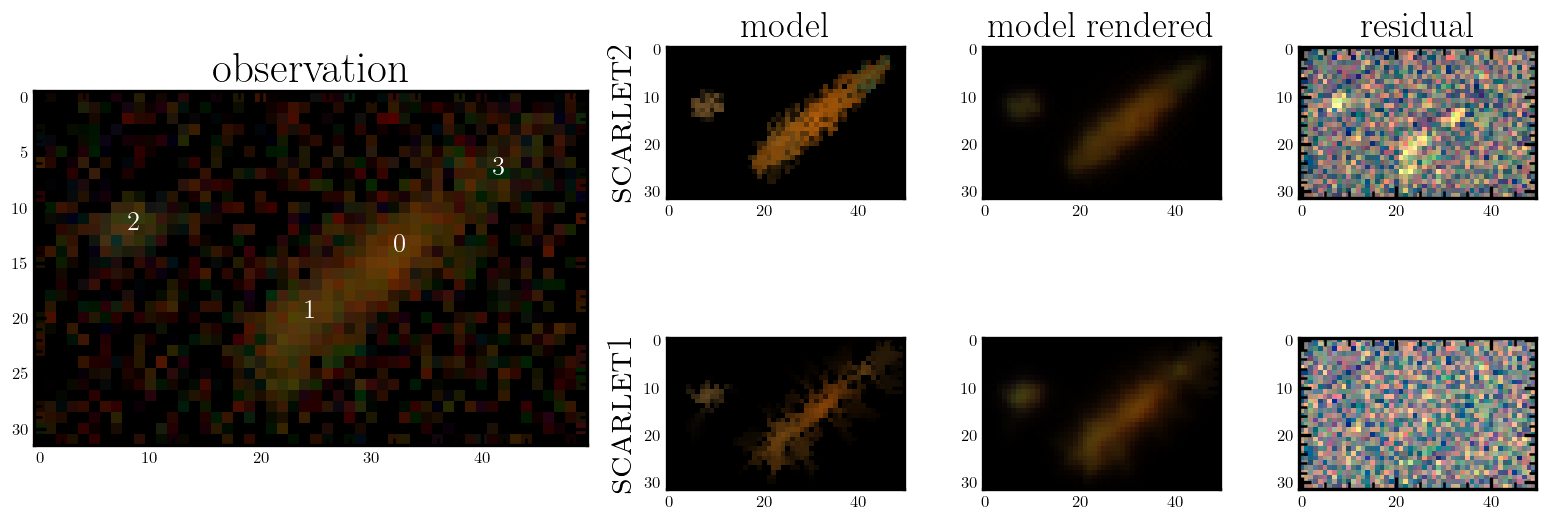

In [21]:
fig = plt.figure(figsize=(13,5),dpi=120)
cmap = 'binary'
cmap_resid = cmr.prinsenvlag
cmap_resid = 'PuOr'

# ------------------------------ #
# make the grid
gs = fig.add_gridspec(2,5)
ax1 = fig.add_subplot(gs[:, 0:2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[1, 3])
ax7 = fig.add_subplot(gs[1, 4])
# ------------------------------ #

# ------------------------------ #
# Scarlet 2 plotting #
# the observations
ax1.imshow(obs_rgb)
ax1.set_title('observation', fontsize = 26)

for k in range(len(centers)):
        y,x = centers[k]
        ax1.text(x, y, k, color="white", fontsize=16)

# the model
ax2.imshow(model_bad_rgb)
ax2.set_title('model', fontsize = 22)
ax2.set_ylabel(r'$\textsc{scarlet}2$', fontsize = 22)

# the renders
ax3.imshow(renders_bad_rgb)
ax3.set_title('model rendered', fontsize = 22)

# the residuals
ax4.imshow(residuals_bad_rgb)
ax4.set_title('residual', fontsize = 22)

# Scarlet 1 
# the model
ax5.imshow(scarlet1_model)
#ax5.set_title('model', fontsize = 17)
ax5.set_ylabel(r'$\textsc{scarlet}1$', fontsize = 22)

# the renders
ax6.imshow(scarlet1_render)

# the residuals
#ax7.imshow(scarlet1_resid)
ax7.imshow(residuals_rgb)
# ------------------------------ #

# save params
fig.tight_layout()
name = 'bad_init_test_2panel_' + str(src_num) + '.png'
name2 = 'bad_init_test_2panel_' + str(src_num) + '.pdf'
plt.savefig(name, dpi=120)
plt.savefig(name2, dpi=120)
plt.show()

Text(0.5, 0, 'source 0')

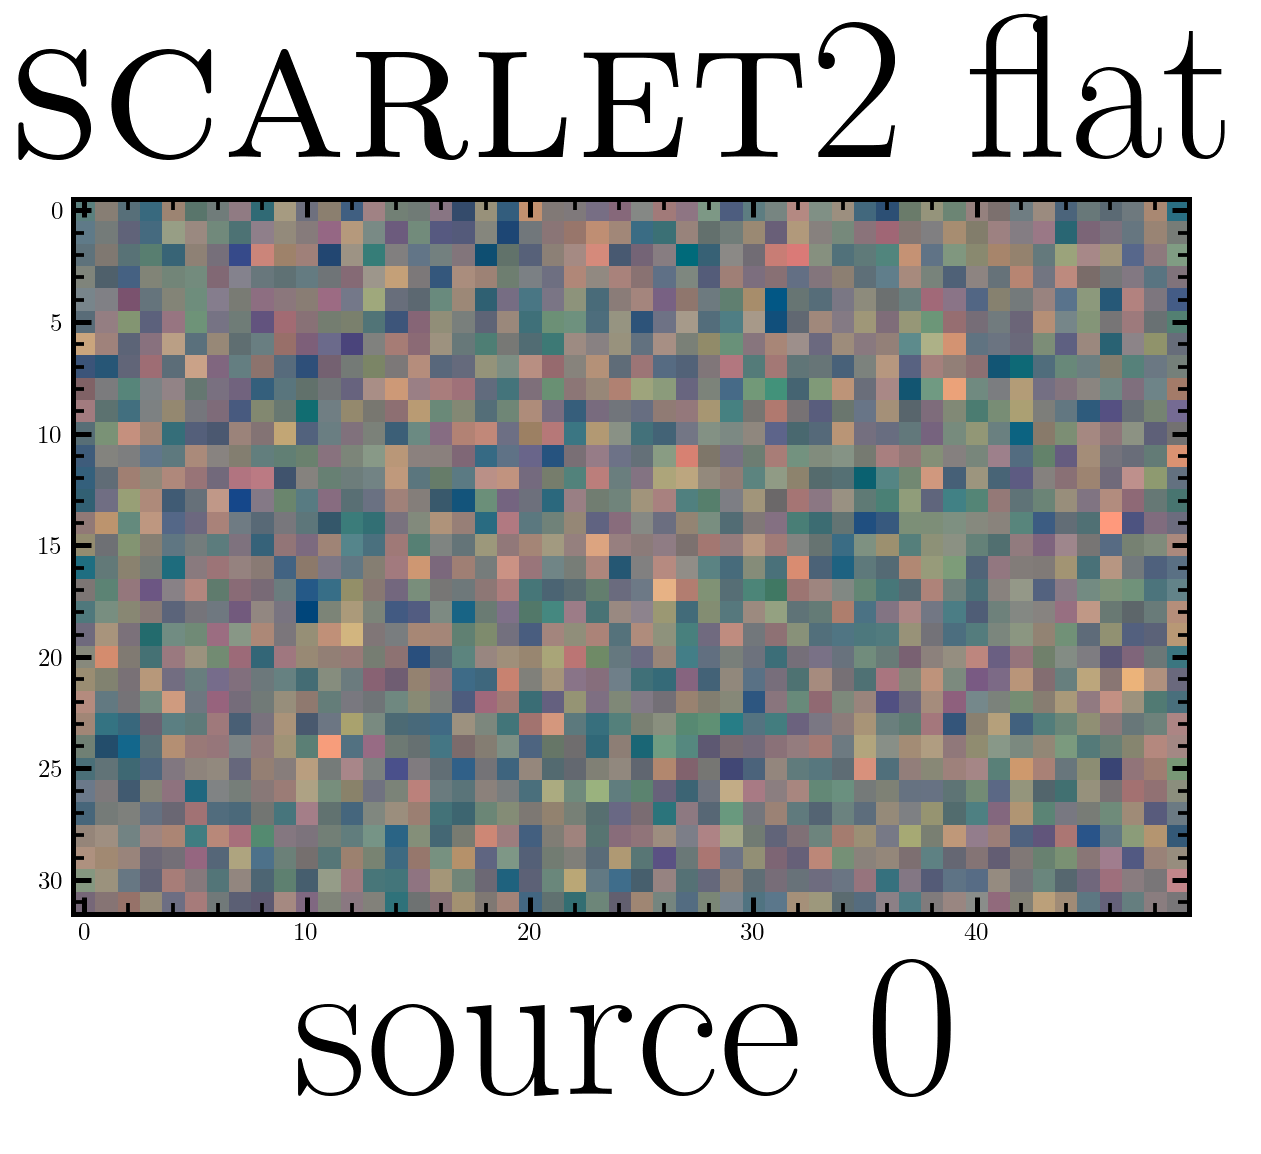

In [22]:
fig = plt.figure(figsize=(8,8),dpi=180)
plt.imshow(scarlet1_resid, cmap='cmr.gothic')
plt.title(r'$\textsc{scarlet}2$  flat',fontsize=82)
plt.xlabel('source 0',fontsize=82)

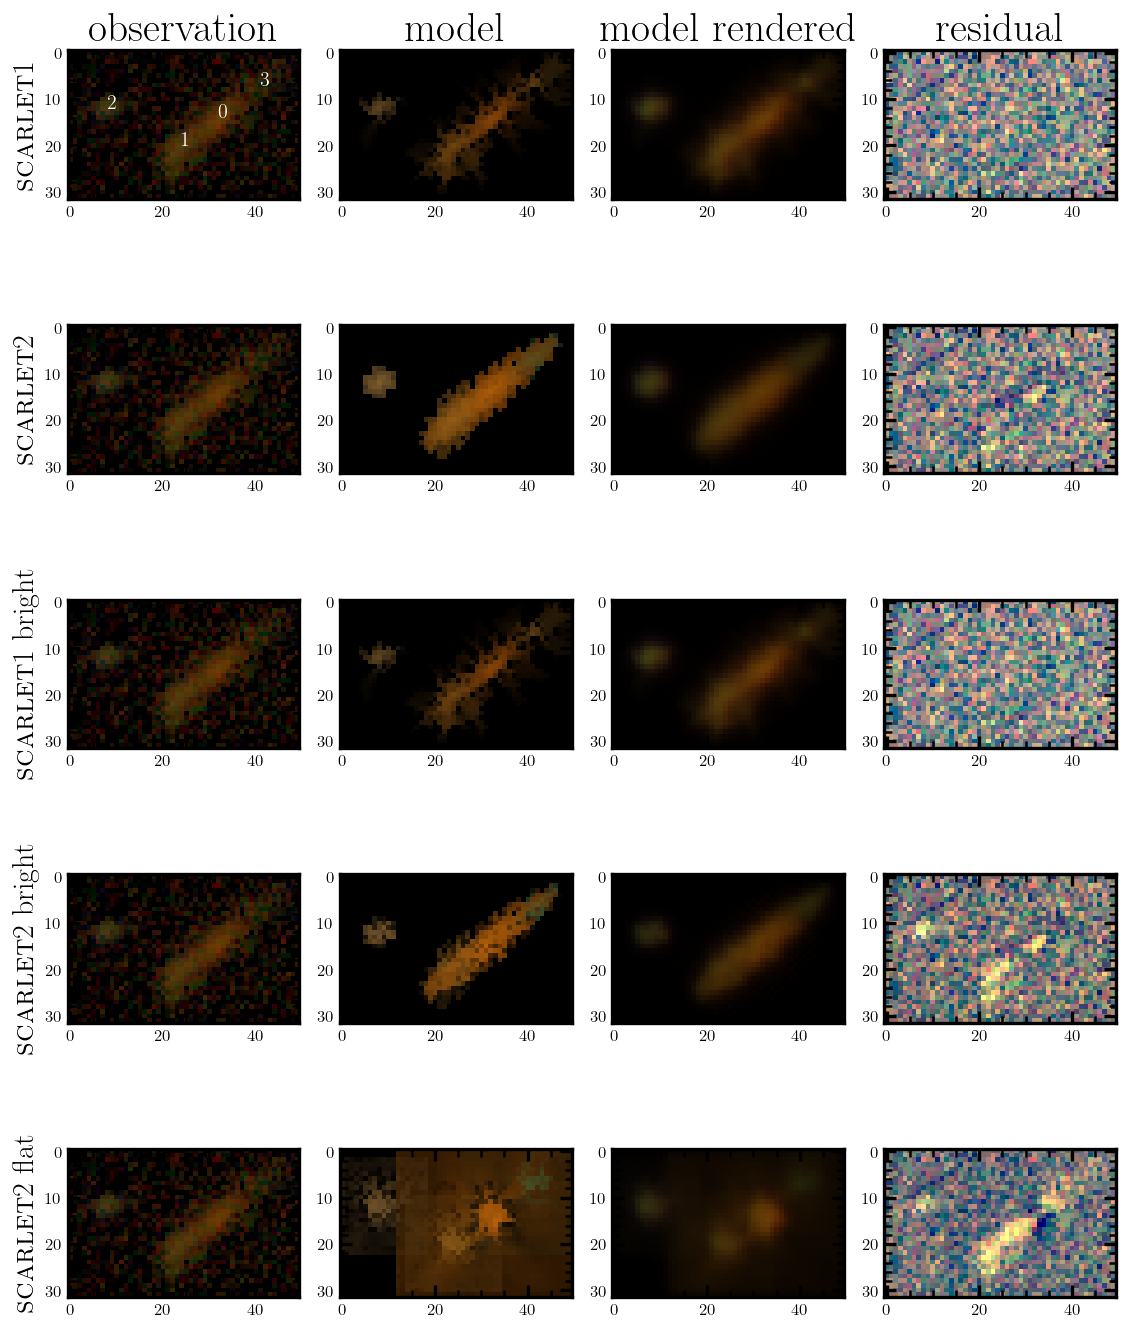

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(9.5,12),dpi=120)
cmap = 'binary'
cmap_resid = cmr.prinsenvlag
cmap_resid = 'PuOr'

# ------------------------------ #
# make the grid
gs = fig.add_gridspec(5,4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[2, 0])
ax10 = fig.add_subplot(gs[2, 1])
ax11 = fig.add_subplot(gs[2, 2])
ax12 = fig.add_subplot(gs[2, 3])
ax13 = fig.add_subplot(gs[3, 0])
ax14 = fig.add_subplot(gs[3, 1])
ax15 = fig.add_subplot(gs[3, 2])
ax16 = fig.add_subplot(gs[3, 3])
ax17 = fig.add_subplot(gs[4, 0])
ax18 = fig.add_subplot(gs[4, 1])
ax19 = fig.add_subplot(gs[4, 2])
ax20 = fig.add_subplot(gs[4, 3])
# ------------------------------ #

# Scarlet 1 
ax1.imshow(obs_rgb)
ax1.set_title('observation', fontsize = 25)
ax1.set_ylabel(r'$\textsc{scarlet}1$', fontsize = 18)
for k in range(len(centers)):
        y,x = centers[k]
        ax1.text(x, y, k, color="white", fontsize=12)
        #ax5.text(x, y, k, color="white", fontsize=12)
        #ax9.text(x, y, k, color="white", fontsize=12)
# the model
ax2.imshow(scarlet1_model_best)
ax2.set_title('model', fontsize = 25)
# the renders
ax3.imshow(scarlet1_render_best)
ax3.set_title('model rendered', fontsize = 25)
# the residuals
ax4.imshow(residuals_rgb_best)
ax4.set_title('residual', fontsize = 25)

# Scarlet 2 plotting #
ax5.imshow(obs_rgb)
ax5.set_ylabel(r'$\textsc{scarlet}2$', fontsize = 18)
# the model
ax6.imshow(model_best_rgb)
# the renders
ax7.imshow(renders_best_rgb)
# the residuals
ax8.imshow(residuals_best_rgb)

# Scerlet random
ax9.imshow(obs_rgb)
ax9.set_ylabel(r'$\textsc{scarlet}1$ bright', fontsize = 18)
# the model
ax10.imshow(scarlet1_model)
# the renders
ax11.imshow(scarlet1_render)
# the residuals
ax12.imshow(residuals_rgb)

# Scerlet random
ax13.imshow(obs_rgb)
ax13.set_ylabel(r'$\textsc{scarlet}2$ bright', fontsize = 18)
# the model
ax14.imshow(model_bad_rgb)
# the renders
ax15.imshow(renders_bad_rgb)
# the residuals
ax16.imshow(residuals_bad_rgb)

# Scerlet random
ax17.imshow(obs_rgb)
ax17.set_ylabel(r'$\textsc{scarlet}2$ flat', fontsize = 18)
# the model
ax18.imshow(model_flat_rgb)
# the renders
ax19.imshow(renders_flat_rgb)
# the residuals
ax20.imshow(residuals_flat_rgb)


# save params
fig.tight_layout()
name = 'bad_init_test' + str(src_num) + '.png'
name2 = 'bad_init_test' + str(src_num) + '.pdf'
plt.savefig(name, dpi=120)
plt.savefig(name2, dpi=120)
plt.show()

In [24]:
print('---------------------------------')
print('        with +ve constraint')
print('---------------------------------')

for i in range(len(scene_flat.sources)):
    test = scene_flat.sources[i].morphology()
    print(f'source {i} max: {np.max(test):.3f}')
    print(f'source {i} min: {np.min(test):.3f}')


print('---------------------------------')
print('      without +ve constraint')
print('---------------------------------')
for i in range(len(scene_bad.sources)):
    test = scene_bad.sources[i].morphology()
    print(f'source {i} max: {np.max(test):.3f}')
    print(f'source {i} min: {np.min(test):.3f}')

---------------------------------
        with +ve constraint
---------------------------------
source 0 max: 2.802
source 0 min: 0.000
source 1 max: 2.057
source 1 min: 0.000
source 2 max: 2.010
source 2 min: 0.000
source 3 max: 1.887
source 3 min: 0.000
---------------------------------
      without +ve constraint
---------------------------------
source 0 max: 2.711
source 0 min: 0.000
source 1 max: 1.719
source 1 min: 0.000
source 2 max: 2.220
source 2 min: 0.000
source 3 max: 2.076
source 3 min: 0.000


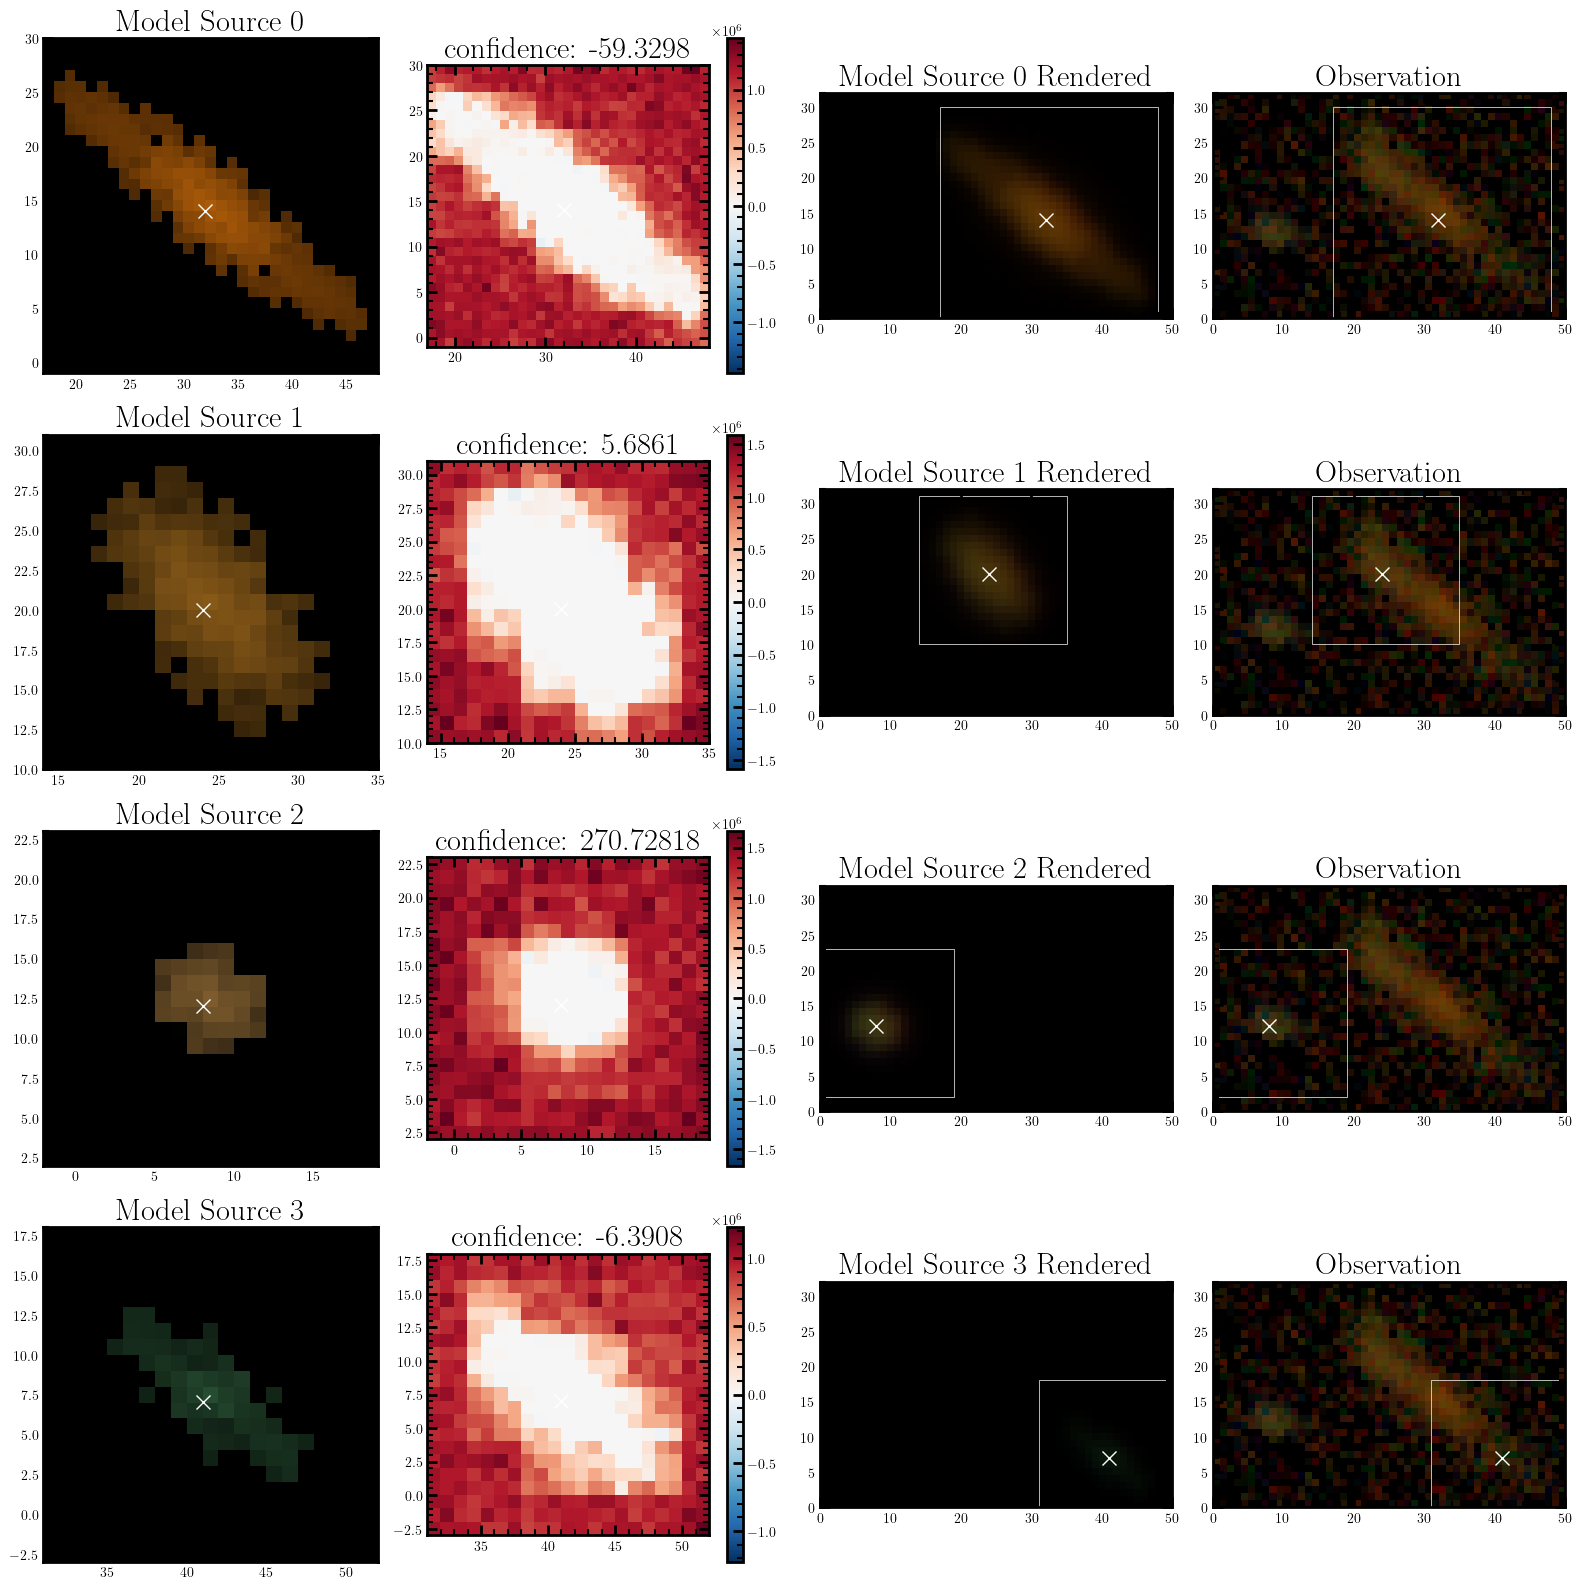

In [25]:
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
scarlet2.plot.sources(scene_best,
            norm=norm,
            observation=obs,
            show_observed=True,
            show_hallucination=True,
            show_model=True,
            show_rendered=True,
            show_spectrum=False,
            add_boxes=True,
            add_markers=True,
            figsize=None,
            )
plt.savefig('sample_scarlet.pdf', dpi=120)
plt.show()

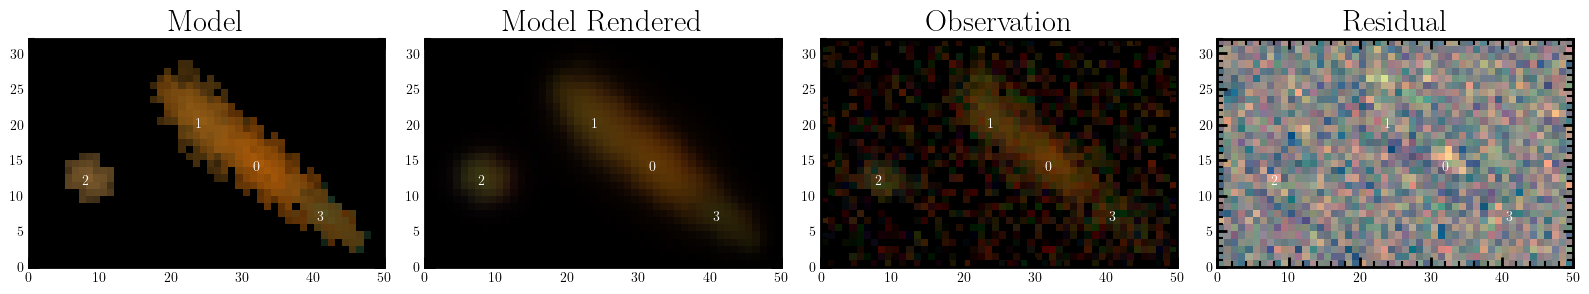

In [26]:
scarlet2.plot.scene(
    scene_best,
    observation=obs,
    norm=norm,
    channel_map=None,
    show_model=True,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=False,
    figsize=None,
    linear=True,
)
plt.savefig('sample_scarlet_panels.pdf', dpi=120)
plt.show()

/var/folders/hq/wy849_h10qlbj1pf5_gxyh9m0000gn/T/ipykernel_60202/4293338664.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


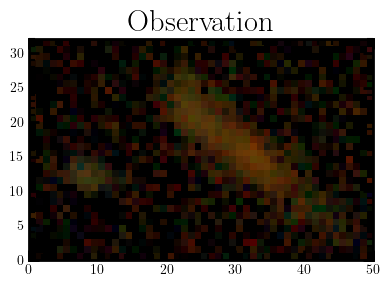

In [27]:
scarlet2.plot.observation(
    observation=obs,
    norm=norm,
    channel_map=None,
    sky_coords=None,
    show_psf=False,
    add_labels=False,
    figsize=None,
)
plt.tight_layout()
plt.savefig('sample_scarlet_obs.pdf', dpi=120)
plt.show()

In [28]:
scene_best.sources[0].spectrum()

Array([0.10413054, 0.8210836 , 3.1755066 , 8.858863  , 6.177459  ],      dtype=float32)

In [29]:
y = [19, 23, 29]
y2 = [14, 63, 146]
x = [1, 5, 10]

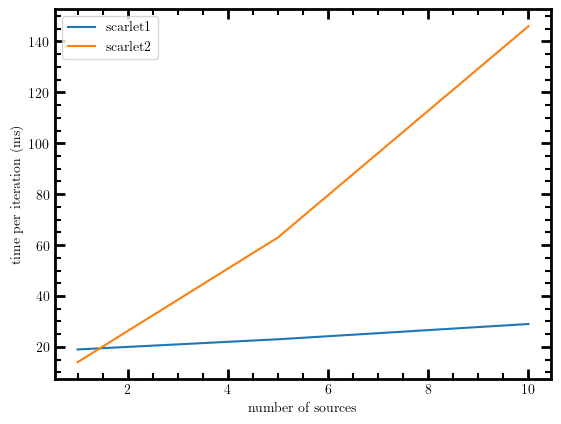

In [30]:
plt.plot(x,y, label='scarlet1')
plt.plot(x,y2, label='scarlet2')
plt.xlabel('number of sources')
plt.ylabel('time per iteration (ms)')
plt.legend()